In [1]:
import pickle 
import pandas as pd
from math import pi
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf


In [2]:
#permite guardar el modelo serializandolo

def save_to_pickle(name, item):
    filehandler = open(name+".pkl", "wb")
    pickle.dump(item, filehandler)
    filehandler.close()

In [3]:
# pinta las metricas de cada epoca....

def plot_metric(history, metric, valida):
    train_metrics = history.history[metric]
    # if valida:
    #    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    if valida:
        val_metrics = history.history['val_' + metric]
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation ' + metric)
    else:
        plt.title('Training ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    if valida:
        plt.legend(["train_"+metric, 'val_' + metric])
    plt.show()

In [4]:
# creacion del modelo de red neuronal
# capa de entrada de usuarios:
#    codificados como one-hot,por lo tanto tiene de dimension el numero 
#    de usuarios distintos del conjunto

#



# K=32
# LR=1e-3
# num_users=943
# num_pelis=1682
# dim_users=dim_pelis=1
# peso_score=0,5  --> lo iremos variando para dar mas peso a entrenar las valoraciones o los géneros

def crear_modelo(K, LR, num_users, num_pelis, dim_users, dim_pelis, peso_score):
    user_input = tf.keras.layers.Input(shape=(dim_users,), name="input_usr")  # Variable-length sequence of ints
    usuarios_emb = tf.keras.layers.Embedding(input_dim=num_users, output_dim=K, name="embedding_usr")(user_input)
    usuarios = tf.keras.layers.Flatten(name="flatten_usr")(usuarios_emb)  # para pasar de (?,1,K) a (?,K)
    
    pelis_input = tf.keras.layers.Input(shape=(dim_pelis,), name="input_pelis")  # Variable-length sequence of ints
    pelis_emb = tf.keras.layers.Embedding(input_dim=num_pelis, output_dim=K, name="embedding_pelis")(pelis_input)
    pelis = tf.keras.layers.Flatten(name="flatten_pelis")(pelis_emb)  # para pasar de (?,1,K) a (?,K)
    # genre_pred = tf.keras.layers.Dense(num_genres, activation='sigmoid', name="genres")(pelis)  # (?, num_genres)
    # genre_pred = tf.keras.layers.Dense(num_genres, activation='tanh', name="genres")(pelis)  # (?, num_genres)

    score_pred = tf.keras.layers.Dot(axes=1, name="scores")([usuarios, pelis])

    model = tf.keras.Model(
        inputs=[user_input, pelis_input],
        outputs=[score_pred],
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        # optimizer=keras.optimizers.RMSprop(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
        # loss_weights=[peso_score, 1 - peso_score],
        metrics=['mean_absolute_error'],  # tf.keras.metrics.BinaryAccuracy()],
    )

    model_usr = tf.keras.Model(
        inputs=[user_input],
        outputs=[usuarios],
    )

    
    #output_array2 = model.predict([valoraciones25M.user_id, valoraciones25M.item_id])
    

    return model, model_usr


In [5]:
def entrenar(VALIDATION, K, epochs, batch_size, learning_rate, peso_score, num_users, num_pelis, dim_input_users,
             dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test):
    # SE CREA EL MODELO
    model, mod_usr = crear_modelo(K, learning_rate, num_users, num_pelis, dim_input_users, dim_input_pelis, peso_score)

    # ENTRENAMOS EL MODELO Y EVALUAMOS EN EL CONJUNTO DE TEST
    if VALIDATION:
        # DECLARAMOS UN OBJETO EARLY STOPPING PARA DECIDIR LA MEJOR EPOCH
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
        # early_stop = EarlyStopping(monitor='val_scores_loss', patience=20)
        csv_logger = tf.keras.callbacks.CSVLogger("model/model_history_25M_mf__log.csv", append=True)
        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_25M_{epoch:06d}.h5', save_best_only=True)
        history = model.fit(x=[X_train.user_id, X_train.item_id], y=[y_train.rating, y_train[col_items]],
                            validation_data=([X_dev.user_id, X_dev.item_id], [y_dev.rating, y_dev[col_items]]),
                            epochs=epochs, batch_size=batch_size, callbacks=[early_stop, checkpoint,csv_logger])
        print('Mejor epoch:', early_stop.stopped_epoch)
        media_en_train = y_train['rating'].mean()
    else:
        if epochs == 0:
            epochs = 1000
        checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_25M_mf+D_{epoch:06d}.h5')
        csv_logger = tf.keras.callbacks.CSVLogger("model/model_history_25M_mf__log.csv", append=True)
        history = model.fit(x=[X_train_dev.user_id, X_train_dev.item_id],
                            y=[y_train_dev.rating, y_train_dev[col_items]],
                            epochs=epochs, batch_size=batch_size, callbacks=[checkpoint,csv_logger])
        media_en_train = y_train_dev['rating'].mean()
        usr_emb_g = mod_usr.predict([X_test.user_id])

    losses = model.evaluate([X_test.user_id, X_test.item_id], [y_test])
    print('\t*-* Test                         loss: %.4f' % losses[0])
    print('\t*-* Test             MAE sobre scores: %.4f' % losses[1])

   
    prediction = model.predict([X_test.user_id, X_test.item_id])
    print('Test MAE    modelo: %.4f' % (sum(abs(y_test['rating'] - prediction[0].flatten())) / y_test.shape[0]))
    print('Test MAE Sys-Media: %.4f' % (sum(abs(y_test['rating'] - media_en_train)) / y_test.shape[0]))

    # GRÁFICOS
    plot_metric(history, 'loss', valida=VALIDATION)
    plot_metric(history, 'mean_absolute_error', valida=VALIDATION)

    if VALIDATION:
        return model, early_stop.stopped_epoch
    else:
        return model, prediction, usr_emb_g



In [6]:
def radar_chart(line_out, df_train_dev, items, names, unames, pnames, prnames):
    print("-------------------------------------------------------------------------------------------------")
    print("----- radar_chart: genera el radar_chart ")
    print("-------------------------------------------------------------------------------------------------")
    num_user = line_out.user_id  #.iloc[line]
    num_peli = line_out.item_id  #.iloc[line]
    titulo_peli = items[items.item_id == num_peli].title.values[0]

    # number of variable
    categories = names  # list(df)[2:]  # para quitar user_id y rating de las etiquetas
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    plt.figure(figsize=(6, 7))
    ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable
    plt.xticks(angles[:-1], categories)

    # ------- PART 2: Add plots
    # Plot each individual = each line of the data
    # I don't make a loop, because plotting more than 3 groups makes the chart unreadable

    # Usuario
    # values_user = line_out[unames].iloc[line].values.tolist()
    values_user = line_out[unames].values.tolist()
    values_user += values_user[:1]
    ax.plot(angles, values_user, linewidth=1, linestyle='solid', label="Usuario - predicho")
    ax.fill(angles, values_user, 'b', alpha=0.1)

    # Predicción géneros película
    values_peli = line_out[pnames].values.tolist()
    values_peli += values_peli[:1]
    ax.plot(angles, values_peli, linewidth=1, linestyle='solid', label="Predicho - "+titulo_peli)
    ax.fill(angles, values_peli, 'r', alpha=0.1)

    # géneros película verdaderos
    true_values_peli = line_out[prnames].values.tolist()
    true_values_peli += true_values_peli[:1]
    ax.plot(angles, true_values_peli, linewidth=1, linestyle='solid', label="Real - "+titulo_peli)
    ax.fill(angles, true_values_peli, 'g', alpha=0.1)

    # Draw ylabels
    ax.set_rlabel_position(0)
    v = max(max(values_user), max(values_peli)) / 4
    plt.yticks([v, v*2, v*3], [str(round(v, 4)), str(round(v*2, 4)), str(round(v*3, 4))], color="grey", size=7)
    plt.ylim(0, max(max(values_user), max(values_peli)))

    # Add legend
    plt.legend(loc='lower left', bbox_to_anchor=(-0.15, -0.23))

    nota_media_users = df_train_dev['rating'].groupby(df_train_dev['user_id']).mean().reset_index()
    nota_media_pelis = df_train_dev['rating'].groupby(df_train_dev['item_id']).mean().reset_index()
    nota_media_usr = nota_media_users[nota_media_users.user_id == num_user].rating.values[0]
    nota_media_peli = nota_media_pelis[nota_media_pelis.item_id == num_peli].rating.values[0]
    titulo = 'Usuario ' + str(int(num_user)) + ' (nota media: ' + str(np.round(nota_media_usr, 2)) + ')\n' + \
             titulo_peli + ' (nota media: ' + str(np.round(nota_media_peli, 2)) + ')\n' + \
             ' Nota predicha: ' + str(np.round(line_out.rating, 2))

    plt.title(titulo)
    # Show the graph
    plt.show()


In [7]:

def topNrankings(N, line_out, names, unames, pnames, prnames, verbose=False):
    # line_out = df_out.iloc[7]
    usuario = line_out[unames].copy()
    usuario.rename(dict(zip(unames, names)), axis='columns', inplace=True)
    peli = line_out[pnames].copy()
    peli.rename(dict(zip(pnames, names)), axis='columns', inplace=True)
    peli_real = line_out[prnames].copy()
    peli_real.rename(dict(zip(prnames, names)), axis='columns', inplace=True)
    top5user = usuario.sort_values(ascending=False)[0:N]
    top5peli = peli.sort_values(ascending=False)[0:N]
    top5real = peli_real.sort_values(ascending=False)[0:N]
    inters_genres = top5user.index & top5peli.index
    if verbose:
        print("-------------------------------------------------------------------------------------------------")
        print("----- topNrankings: muestra los TopN y calcula la intersección ")
        print("-------------------------------------------------------------------------------------------------")
        print("Top", N, "de géneros del usuario según el modelo:")
        print(top5user)
        print("Top", N, "de géneros de la película según el modelo:")
        print(top5peli)
        print("Top", N, "de géneros de la película según MovieLens:")
        print(top5real)
        print("Intersección usuario-película en top", N, "según el modelo:")
        print(inters_genres)
        print("Número de elementos en la intersección:", len(inters_genres))
        print("Puntuación predicha (real) para la película: %.2f (%.0f)" % (line_out.rating, line_out.rat_real))
    return len(inters_genres)


In [8]:

def genres_bar_chart(genre_names, gen_reales, gen_predichos):
    x = np.arange(len(genre_names))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, gen_reales, width, label='Géneros reales')
    rects2 = ax.bar(x + width / 2, gen_predichos, width, label='Géneros predichos')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    # ax.set_ylabel('media')
    ax.set_title('Media de géneros de las películas')
    ax.set_xticks(x)
    ax.set_xticklabels(genre_names, rotation='vertical')
    ax.legend()

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    fig.tight_layout()
    plt.show()


In [9]:

def compara_generos(df_out, pnames, prnames):
    dfo = df_out[pnames + prnames].groupby(df_out['item_id']).mean().reset_index()
    # genres_bar_chart(names, dfo[prnames].sum(), dfo[pnames].sum())
    genres_bar_chart(names, dfo[prnames].mean(), dfo[pnames].mean())
    print('Correlación: ', np.corrcoef(dfo[prnames].mean(), dfo[pnames].mean())[0,1])
    dfo[dfo[pnames] < 0.5] = 0
    dfo[dfo[pnames] >= 0.5] = 1
    genres_por_peli_pred = np.sum(dfo[pnames], axis=1)
    genres_por_peli_real = np.sum(dfo[prnames], axis=1)
    print("-------------------------------------------------------------------------------------------------")
    print("----- compara_generos: genera el barchart y muestra media de géneros por película")
    print("-------------------------------------------------------------------------------------------------")
    print("Media de géneros por película en test (real):", genres_por_peli_real.mean())
    print("Media de géneros por película en test (pred):", genres_por_peli_pred.mean())
    dfo['dif_genres'] = genres_por_peli_pred - genres_por_peli_real
    dfo.to_csv('dif_genres.csv', sep=';', decimal=',')



In [10]:
def explica(linea, df_out, df_train_dev, items, names, unames, pnames, prnames):
    print("-------------------------------------------------------------------------------------------------")
    print("----- explica: muestra qué géneros influyen más en la valoración")
    print("-------------------------------------------------------------------------------------------------")
    importancia_genres = np.multiply(df_out[unames], df_out[pnames])
    print("Valor predicho: %.2f" % (importancia_genres.iloc[linea].sum()))
    genres_ordenados = importancia_genres.iloc[linea].sort_values(ascending=False)
    print("Géneros que más aportan:")
    print(genres_ordenados[0:5])
    suma = genres_ordenados[0:5].sum()
    print("Aportan el %.2f%% de la nota predicha (%.2f de %.2f)" % (suma*100 / importancia_genres.iloc[linea].sum(),
                                                                    suma, importancia_genres.iloc[linea].sum()))
    # aportación de los géneros con predicción >=05
    mask = df_out.iloc[linea][pnames] >= 0.5
    gen_ge_05 = importancia_genres.iloc[linea, mask.values.tolist()]
    print("Aportación de los géneros >= 0.5:")
    print(gen_ge_05.sort_values(ascending=False))
    suma = gen_ge_05.sum()
    print("Aportan el %.2f%% de la nota predicha (%.2f de %.2f)" % (suma * 100 / importancia_genres.iloc[linea].sum(),
                                                                    suma, importancia_genres.iloc[linea].sum()))


In [11]:
# MAIN
# ---------------------------------------------------------------------------------------------------------------------

#path alfa
#PATH='../paper_generos_peliculas/XAI_movies/cjtos/ml-25M/'
#path M1
PATH='/Users/antonio/OneDrive - farmasturias.org/DOCTORADO/paper_generos_peliculas/XAI_movies/cjtos/ml-25M/'

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# VALORACIONES
# ---------------------------------------------------------------------------------------------------------------------

# Ponemos las dos variables como parametro fijo para agilizar las ejecuciones  
num_users=162542    
num_pelis=209172
num_genres=19 
print('num_genres',num_genres)
print('num_users ',num_users)
print('num_pelis ',num_pelis)

num_genres 19
num_users  162542
num_pelis  209172


In [12]:
### CARGO LOS DATOS PREPROCESADOS EN SQL 

cjto=pd.read_csv(PATH+'generos_estaticos.csv',index_col=False)
cjto=cjto.rename(columns={'userid':'user_id'})
X=cjto.drop(['rating'],axis='columns')
y = cjto['rating'].copy()
col_items=cjto.columns.drop(['user_id','item_id', 'rating'])
TEST = 0.10
DEV = 0.10

In [13]:
X = cjto[['user_id', 'item_id']].copy()
X

,user_id,item_id
0,77267,4979
1,77267,4993
2,77267,5010
3,77267,5013
4,77267,5023
...,...,...
25000090,77267,4890
25000091,77267,4896
25000092,77267,4941
25000093,77267,4963


In [14]:
y = cjto[col_items.insert(0, 'rating')].copy()
y

,rating,0_Action,0_Adventure,0_Animation,0_Children,0_Comedy,0_Crime,0_Documentary,0_Drama,0_Fantasy,0_Film-Noir,0_Horror,0_IMAX,0_Musical,0_Mystery,0_Romance,0_Sci-Fi,0_Thriller,0_War,0_Western
0,4.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,3.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
3,3.5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
4,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25000090,4.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
25000091,4.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
25000092,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
25000093,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [15]:
TEST = 0.10
DEV = 0.10

# TRAIN/DEV/TEST SPLIT (sin estratificar para prevenir errores)

X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, stratify=None, test_size=TEST, random_state=2032)

X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, stratify=None,
                                                  test_size=DEV, random_state=2032)

print("% test =", TEST, "\n% dev =", DEV)
print("X_train:", X_train.shape)
print("X_dev  :", X_dev.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_dev  :", y_dev.shape)
print("y_test :", y_test.shape)

% test = 0.1 
% dev = 0.1
X_train: (20250076, 2)
X_dev  : (2250009, 2)
X_test : (2500010, 2)
y_train: (20250076, 20)
y_dev  : (2250009, 20)
y_test : (2500010, 20)


In [18]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# ENTRENAMIENTO
# ---------------------------------------------------------------------------------------------------------------------
K = 32
learning_rate = 1e-3
dim_input_users = 1  # el entero a partir del cual se calcula el embedding ##????
dim_input_pelis = 1  # el entero a partir del cual se calcula el embedding ##????
tam_batch = 512 
max_epochs = 1000
peso_score = 0.5  # valor entre 0 y 1.0

In [19]:
max_epochs

1000

Epoch 1/1000
39551/39551 [==============================] - 1065s 27ms/step - loss: 3.9756 - mean_absolute_error: 1.4643 - val_loss: 0.8129 - val_mean_absolute_error: 0.6839
Epoch 2/1000
39551/39551 [==============================] - 1070s 27ms/step - loss: 0.7623 - mean_absolute_error: 0.6625 - val_loss: 0.7100 - val_mean_absolute_error: 0.6383
Epoch 3/1000
39551/39551 [==============================] - 1071s 27ms/step - loss: 0.6469 - mean_absolute_error: 0.6094 - val_loss: 0.6674 - val_mean_absolute_error: 0.6182
Epoch 4/1000
39551/39551 [==============================] - 1060s 27ms/step - loss: 0.5768 - mean_absolute_error: 0.5739 - val_loss: 0.6545 - val_mean_absolute_error: 0.6121
Epoch 5/1000
39551/39551 [==============================] - 1047s 26ms/step - loss: 0.5350 - mean_absolute_error: 0.5516 - val_loss: 0.6534 - val_mean_absolute_error: 0.6116
Epoch 6/1000
39551/39551 [==============================] - 1049s 27ms/step - loss: 0.5090 - mean_absolute_error: 0.5369 - val_los

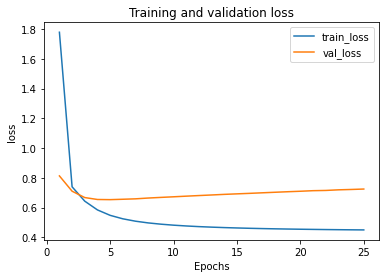

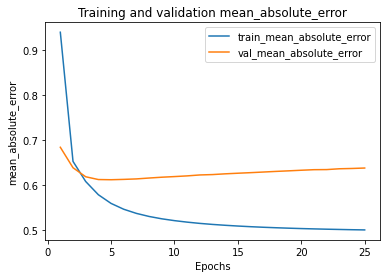

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_usr (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_pelis (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_usr (Embedding)       (None, 1, 32)        5201344     input_usr[0][0]                  
__________________________________________________________________________________________________
embedding_pelis (Embedding)     (None, 1, 32)        6693504     input_pelis[0][0]                
______________________________________________________________________________________________

In [20]:
# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN -> DEV Y TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = True
model, n_epochs = entrenar(VALIDATION, K, max_epochs, tam_batch, learning_rate, peso_score, num_users, num_pelis,
                           dim_input_users, dim_input_pelis, X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)

model.summary()

In [ ]:

# ---------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------
# TRAIN+DEV -> TEST
# ---------------------------------------------------------------------------------------------------------------------
VALIDATION = False
model, prediction, usr_emb_genres = entrenar(VALIDATION, K, n_epochs, tam_batch, learning_rate, peso_score, num_users,
                                        num_pelis, dim_input_users, dim_input_pelis,
                                        X_train, X_train_dev, X_test, y_train, y_train_dev, y_test)

save_to_pickle('ml25M_prediction', prediction)

Epoch 1/24
43946/43946 [==============================] - 1214s 28ms/step - loss: 3.8128 - mean_absolute_error: 1.4229
Epoch 2/24
43946/43946 [==============================] - 1184s 27ms/step - loss: 0.7322 - mean_absolute_error: 0.6493
Epoch 3/24
43946/43946 [==============================] - 1143s 26ms/step - loss: 0.6327 - mean_absolute_error: 0.6028
Epoch 4/24
43946/43946 [==============================] - 1127s 26ms/step - loss: 0.5712 - mean_absolute_error: 0.5712
Epoch 5/24
43946/43946 [==============================] - 1159s 26ms/step - loss: 0.5341 - mean_absolute_error: 0.5511
Epoch 6/24
43946/43946 [==============================] - 1231s 28ms/step - loss: 0.5107 - mean_absolute_error: 0.5379
Epoch 7/24
43946/43946 [==============================] - 1198s 27ms/step - loss: 0.4955 - mean_absolute_error: 0.5291
Epoch 8/24
43946/43946 [==============================] - 1206s 27ms/step - loss: 0.4851 - mean_absolute_error: 0.5228
Epoch 9/24
43946/43946 [========================

In [ ]:
# se crea un df con los datos de TRAIN+DEV [idusr, iditem, rating, genres]
df_train_dev = X_train_dev.copy()
df_train_dev[y_test.columns] = y_train_dev

# unos que hay en la predicción y en el test
print('UNOS en la predicción:', sum(sum(prediction[1] > 0.5)))
print('UNOS en el test:      ', sum(sum(y_test.values[:, 1:] > 0.5)))

# se crea un df con los datos de TEST [idusr, iditem, rating, genres]
# df_test = X_test.copy()
# df_test[y_test.columns] = y_test

# se crea un df con los datos PREDICHOS [idusr, iditem, rating, genres]
# df_pred = X_test.copy()
# df_pred['rating'] = prediction[0]
# df_pred[y_test.columns[1:]] = prediction[1]

# se crea un dataframe con toda la salida
df_out = X_test.copy()
df_out['rating'] = prediction[0]
df_out['rat_real'] = y_test['rating']
unames = ['u_' + g for g in y_test.columns[1:]]
df_out[unames] = usr_emb_genres  # esto es el mapeado de usuarios en el espacio de géneros
pnames = ['p_' + g for g in y_test.columns[1:]]
df_out[pnames] = prediction[1]  # esto es el mapeado de películas en el espacio de géneros
prnames = ['pr_' + g for g in y_test.columns[1:]]  # pr = películas real
df_out[prnames] = y_test[y_test.columns.drop('rating')]  # esto son los géneros de las películas según MovieLens

# lista con los nombre de los géneros
names = y_test.columns[1:]

# esto es para calcular la intersección de géneros en el top 5 y 10
# esto tarda un poco, así que lo comento y **sólo hay que descomentarlo para los RESULTADOS FINALES**
#df_out['intersecTop5'] = df_out.apply(lambda row: topNrankings(5, row, names, unames, pnames, prnames), axis=1)
#df_out['intersecTop10'] = df_out.apply(lambda row: topNrankings(10, row, names, unames, pnames, prnames), axis=1)
#df_out.to_csv('salida.csv', sep=';', decimal=',')


# hace el barchart
compara_generos(df_out, pnames, prnames)

EXPLICA = True
if EXPLICA:
    # Este código es para ver la recomendación que se hace a un usuario sobre las películas que ha valorado en el test
    # Se cogen las películas que ha valorado y se ordenan por el valor predicho por el modelo
    # Después se analiza y explica la recomendación de la película con mayor valoración (línea 0)
    num_usuario = 542  # 712 puede ser un buen ejemplo, 4 starwars, 8 pulpfiction, 9 elpacienteingles

    print("  ---***--- PREDICCIÓN PARA EL USUARIO %d ---***---" %(num_usuario))
    out_by_user = df_out[df_out.user_id == num_usuario].sort_values(by='rating', ascending=False)
    linea = 0  # en la línea 0 de out_by_user está la más valorada y por tanto la recomendada
    # radar_chart(df_out.iloc[linea], df_train_dev, items, names, unames, pnames, prnames)
    radar_chart(out_by_user.iloc[linea], df_train_dev, items, names, unames, pnames, prnames)
    topNrankings(5, out_by_user.iloc[linea], names, unames, pnames, prnames, verbose=True)
    explica(linea, out_by_user, df_train_dev, items, names, unames, pnames, prnames)

# esta es la media de géneros en las películas evaluadas por los usuarios
# NO tiene en cuenta las valoraciones
# gustos_usuarios_train = df_train_dev[y_test.columns].groupby(df_train_dev['user_id']).mean().reset_index()


# la predicción que se hace del género de las películas puede ser ligeramente diferente
# de los géneros reales. Eso haría que la proyección de los usuarios en el espacio de los
# géneros sirva para hacer predicciones mejores
# mostar: la proyección del usuario y la película en el espacio de géneros. Ahí se verá que
# géneros son importantes para el usuario a la hora de puntuar la película. Además se puede
# comparar el vector de géneros verdadero de la película con el predicho.
# Hay que ver cómo se hace para que el modelo mapee los usuarios en el espacio de los géneros
# para poder mostrarlos en la explicación

print('hiperparámetros: K=%d, batch_size=%d, learning_rate=%f, peso_score=%.2f' % (K, tam_batch, learning_rate,
                                                                                   peso_score))
print("FIN")
